# Choosing the best ramp profile

In [1]:
from pathlib import Path
import os

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize, differential_evolution, basinhopping
from pandas import Series, DataFrame
import pandas as pd

import teslamax
from teslamax import TeslaMaxGeometry, TeslaMaxPreDesign, TeslaMaxModel

import nemplot

from IPython.display import display, HTML

In [2]:
DICT_LINES = 19
K_CRITIC = 0.002
K_STEP = 0.001

In [3]:
os.chdir(str(Path.home() / "code" / "TeslaMax"))

In [4]:
os.getcwd()

'C:\\Users\\fabiofortkamp\\code\\TeslaMax'

In [5]:
def filter_table_from_column(table,column,value):
    """
    Return a view into the 'table' DataFrame, selecting only the rows where
    'column' equals 'value'
    """
    
    return table[table[column] == value]

In [6]:
# Fixed parameters

FIXED_PARAMETERS_AMR = {
    "D_p[m]": 0.35e-3,
    "L[m]": 85e-3,
    "W[m]": 30e-3,
    "N_r[]": 10,
    "T_H[K]": 305.5,
    "dT[K]": 35,
    "Casing material": "Stainless steel",
    "t_casing[m]": 0.5e-3,
    "t_air[m]": 1e-3,
    "N_layers[]": 3,
    "T_C_layers[K]": np.array([273,283,290]),
    "Length_fraction_layers[%]": np.array([20,20,60]),
    "B_min[T]": 0.05}

FIXED_PARAMETERS_MAGNET = {"R_i": 0.015,
                "R_o": 0.040,
                "h_fc": 0.005,
                "R_e": 0.3,
                "n_II": 2,
                "n_IV": 4,
                "phi_C_II": 15,
                "mu_r_II": 1.05,
                "mu_r_IV": 1.05,
              "linear_iron": 1,
              "mu_r_iron": 5e3,
             }

## Compact AMRs

By keeping other parameters constant, and keeping the magnetization fraction at 35%, we can generate a map of AMR performance as a function of regenerator height:

In [7]:
display(HTML("<table><tr><td><img src='figures/Qc_H_regW30.png' width=500></td><td><img src='figures/COP_H_regW30.png' width=500></td></tr></table>"))

,


Now, based on the previous magnet and AMR maps, we select an external radius od 120 mm and internal radius of 50 mm, and we vary the air gap height, to see the ability of the TeslaMax model to generate these magnetic profiles.

In [8]:
def get_hgap_map_vectors(R_s,phi_S):
    """
    Return (h_gap, B_max, K) as arrays to be plotted with contourf, 
    based on the magnet optimization maps for 'R_s' and 'phi_S'
    """
    
    filename = "map_K_Rs_%d.txt" %(R_s,)
    
    file_path = Path(filename)
    
    # read the parameters at the header of the file,
    # to extract the number of segments and format the table
    with open(file_path) as f:
        flines = f.readlines()
    
    hgap_map_dict_lines = 14
    
    params = eval("".join(flines[0:hgap_map_dict_lines]))
    
    # parse the results file
    column_names = ["phi_S[deg]",
                    "h_gap[mm]",
                    "B_max[T]",
                   "K[]"]
    
    map_table = pd.read_csv(filename,sep='\t',skiprows=hgap_map_dict_lines,names=column_names,header=0)

    map_table = filter_table_from_column(map_table,"phi_S[deg]",phi_S)
    
    # tip to use pivot from
    # https://stackoverflow.com/questions/24032282/create-contour-plot-from-pandas-groupby-dataframe
    mp = map_table.pivot('B_max[T]','h_gap[mm]','K[]')
     
    X=mp.columns.values
    Y=mp.index.values
    K=mp.values
    h_gap, B_max =np.meshgrid(X, Y)
    
    return (h_gap,B_max,K)

In [9]:
def plot_K_maps(R_s,phi_S):
    
        
    fig, ax = nemplot.create_plot(xlabel=r'$h\ped{gap}\,[\si{\mm}]$',
                             ylabel=r'$B\ped{max}\,[\si{\tesla}]$')

    h_gap, B_max, K = get_hgap_map_vectors(R_s,phi_S)
    
    K_min = np.min(K)
    K_max = np.max(K)
    
    if K_min <= K_CRITIC:
        
        K_values = np.arange(0,K_max+K_STEP,K_STEP)
    else:
        K_values = None
        
    h_gap_contour = ax.contourf(h_gap,B_max,K,
                                levels=K_values,
                                cmap='jet')
        
    h_gap_colorbar = fig.colorbar(h_gap_contour,
                                  ax=ax,
                                 format='%.3f',
                                 ticks=K_values)
    
    h_gap_colorbar.set_label(r'$K\,[\ ]$')

    ax.set_xticks(np.linspace(np.min(h_gap),np.max(h_gap),11))
    
    nemplot.save_figure(fig,"map_K_hgap_Rs_%d_phi_%d" %(R_s,phi_S))

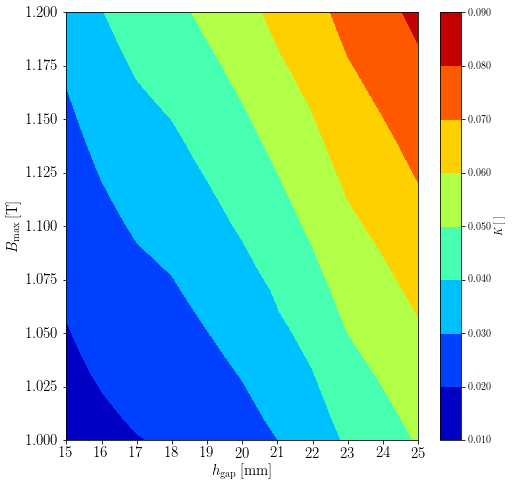

In [10]:
%matplotlib inline
plot_K_maps(100,35)

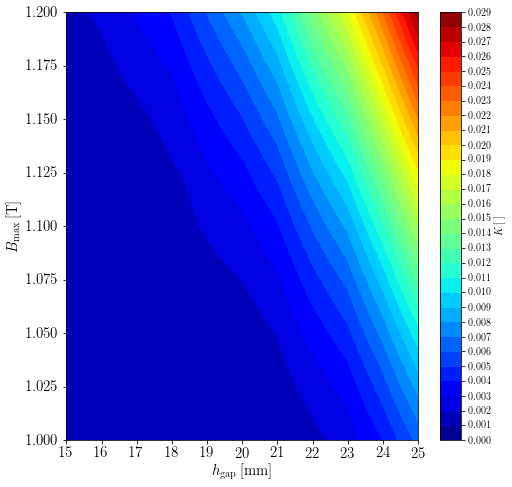

In [11]:
plot_K_maps(100,45)

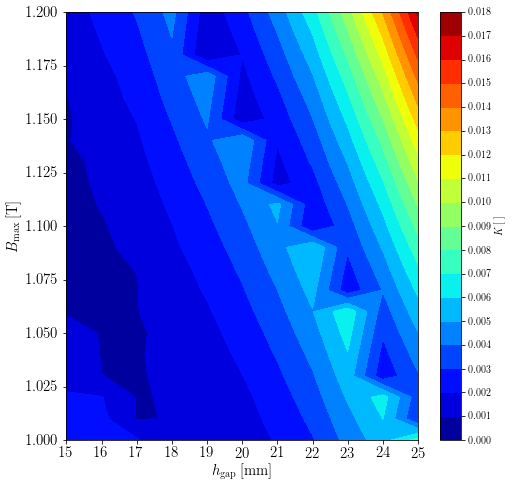

In [12]:
plot_K_maps(100,55)

The critical value of the cost function is $K \le 0.002$. See the **TeslaMax Optimization** notebook for examples.

## Maps for R_s

These maps shows the minimum value of $R\ped{s}$ that will yield a cost function less than the critical value, for a given pair of (air gap height, maximum field). Some values of $R\ped{o}$ are tested, and other parameters are fixed (check the files `map_Rs_Ro_XX.txt` for more information).

In [13]:
def get_Rs_map_vectors(R_o,phi_S):
    """
    Return (h_gap, B_max, R_s) as arrays to be plotted with contourf,
    from the results file for 'R_o' (in mm), selecting only the rows
    with dividing angle 'phi_S' [deg]
    """
    
    filename = "map_Rs_Ro_%d.txt" %(R_o,)
    
    file_path = Path(filename)
    
    # read the parameters at the header of the file,
    # to extract the number of segments and format the table
    with open(file_path) as f:
        flines = f.readlines()
        
    params = eval("".join(flines[0:DICT_LINES]))
    
    n = params["n_II"] + params["n_IV"]
    
    # parse the results file
    column_names = ["phi_S[deg]",
                   "h_gap[mm]",
                   "B_max[T]",
                    "R_s[mm]",
                   "K[]"] 
    
    map_table = pd.read_csv(filename,sep='\t',skiprows=DICT_LINES,names=column_names,header=0)
    
    map_table = filter_table_from_column(map_table,'phi_S[deg]',phi_S)
    
    # tip to use pivot from
    # https://stackoverflow.com/questions/24032282/create-contour-plot-from-pandas-groupby-dataframe
    mp = map_table.pivot('B_max[T]','h_gap[mm]','R_s[mm]')
    
    X=mp.columns.values
    Y=mp.index.values
    R_s=mp.values
    h_gap, B_max =np.meshgrid(X, Y)
    
    return (h_gap,B_max,R_s)

For the inner magnet radius of 40 mm, for an angle of 45°:

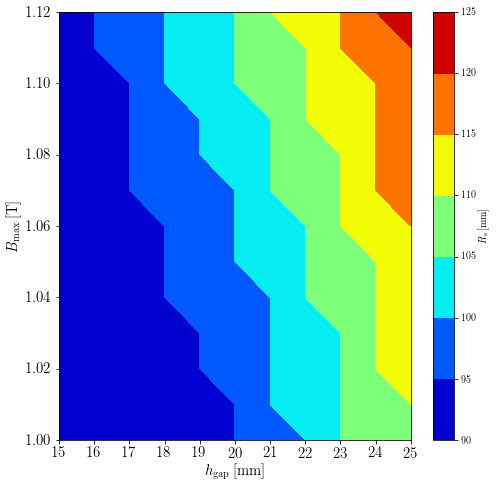

In [14]:
%matplotlib inline

fig, ax = nemplot.create_plot(xlabel=r'$h\ped{gap}\,[\si{\mm}]$',
                             ylabel=r'$B\ped{max}\,[\si{\tesla}]$')

h_gap, B_max, R_s = get_Rs_map_vectors(40,45)

R_s_contour = ax.contourf(h_gap,B_max,R_s,cmap='jet')

ax.set_xticks(np.linspace(np.min(h_gap),np.max(h_gap),11))

R_s_colorbar = fig.colorbar(R_s_contour,ax=ax)
R_s_colorbar.set_label(r'$R\ped{s}\,[\si{\mm}]$')

and for an angle of 55°:

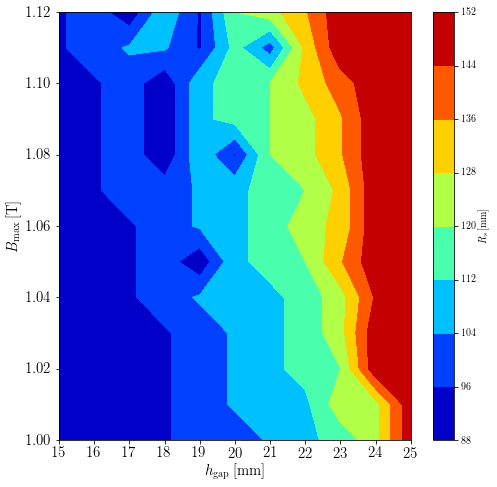

In [15]:
%matplotlib inline

fig, ax = nemplot.create_plot(xlabel=r'$h\ped{gap}\,[\si{\mm}]$',
                             ylabel=r'$B\ped{max}\,[\si{\tesla}]$')

h_gap, B_max, R_s = get_Rs_map_vectors(40,55)

R_s_contour = ax.contourf(h_gap,B_max,R_s,cmap='jet')

ax.set_xticks(np.linspace(np.min(h_gap),np.max(h_gap),11))

R_s_colorbar = fig.colorbar(R_s_contour,ax=ax)
R_s_colorbar.set_label(r'$R\ped{s}\,[\si{\mm}]$')

Due to the computational cost of these simulations, the resolution for the axes are low, and hence these maps should only give loose indications of the required size of the magnet for a given profile. The actual shape of the profile should be checked with other simulations.

It is interesting to see that the contours of constant radius are nearly vertical --- which means that, for a constant external radius, it is possible to achieve different profiles when the gap has a constant geometry (just by varying the remanence angles), making it worth to try to use the smallest gap possible.